In [1]:
# Make all the imports
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pickle

In [2]:
# utility functions

def process_jpg_image(img):
  img = tf.convert_to_tensor(img[:,:,:3])
  img = np.expand_dims(img, axis = 0)
  img = tf.image.resize(img,[224,224])
  img = (img/255.0)
  return img

def show_confusion_matrix(cm, labels):
    '''
    plots heatmap of confusion matrix'''
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [3]:
# Load all the images. training folder is split 20% as validation set and testing folder is loaded as test dataset.

train_dir = r"D:\CDriveDesktopData\Sem 6\Mini-Proj-ML\Mini Project\dataset"
preprocess_input = tf.keras.applications.vgg16.preprocess_input
TARGET_SIZE = 224
BATCH_SIZE = 64


train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset="training",
                                                    shuffle = True,
                                                    target_size=(TARGET_SIZE,TARGET_SIZE))

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset="validation",
                                                    shuffle = False,
                                                    target_size=(TARGET_SIZE,TARGET_SIZE))


Found 500 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [4]:
# Print all the classes

train_generator.class_indices

{'fake': 0, 'real': 1}

In [5]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64, 2)


In [6]:
# Using a VGG model for training

from tensorflow.keras.applications.vgg16 import VGG16


base_model = VGG16(weights='imagenet', input_shape=(TARGET_SIZE, TARGET_SIZE, 3), include_top=False)
base_model.trainable = False

# Adding a model on top

inputs = tf.keras.Input(shape=(TARGET_SIZE, TARGET_SIZE, 3))

x = base_model.output
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

vgg = tf.keras.Model(inputs=base_model.input, outputs=output)


In [7]:
vgg.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
opt = tf.keras.optimizers.Adam()
cce = tf.keras.losses.BinaryCrossentropy()
vgg.compile(optimizer=opt, loss=cce, metrics= ['acc'])

In [9]:
checkpoint_filepath = '/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [10]:
EPOCHS = 15
NUM_STEPS = train_generator.samples/BATCH_SIZE
VAL_NUM_STEPS = validation_generator.samples/BATCH_SIZE
model = vgg.fit(train_generator, epochs = EPOCHS, steps_per_epoch = NUM_STEPS, validation_steps = VAL_NUM_STEPS, validation_data = validation_generator, callbacks=[reduce_lr])

Epoch 1/15
7/7 [==============================] - 117s 15s/step - loss: 0.7208 - acc: 0.5660 - val_loss: 0.6379 - val_acc: 0.5680 - lr: 0.0010
Epoch 2/15
7/7 [==============================] - 112s 15s/step - loss: 0.6601 - acc: 0.6060 - val_loss: 0.6155 - val_acc: 0.8160 - lr: 0.0010
Epoch 3/15
7/7 [==============================] - 115s 15s/step - loss: 0.6198 - acc: 0.7160 - val_loss: 0.5854 - val_acc: 0.8320 - lr: 0.0010
Epoch 4/15
7/7 [==============================] - 114s 15s/step - loss: 0.5965 - acc: 0.7240 - val_loss: 0.5383 - val_acc: 0.8160 - lr: 0.0010
Epoch 5/15
7/7 [==============================] - 116s 15s/step - loss: 0.5666 - acc: 0.7200 - val_loss: 0.5034 - val_acc: 0.7680 - lr: 0.0010
Epoch 6/15
7/7 [==============================] - 116s 15s/step - loss: 0.5364 - acc: 0.7660 - val_loss: 0.4637 - val_acc: 0.8640 - lr: 0.0010
Epoch 7/15
7/7 [==============================] - 117s 15s/step - loss: 0.5136 - acc: 0.8020 - val_loss: 0.4314 - val_acc: 0.9040 - lr: 0.0010

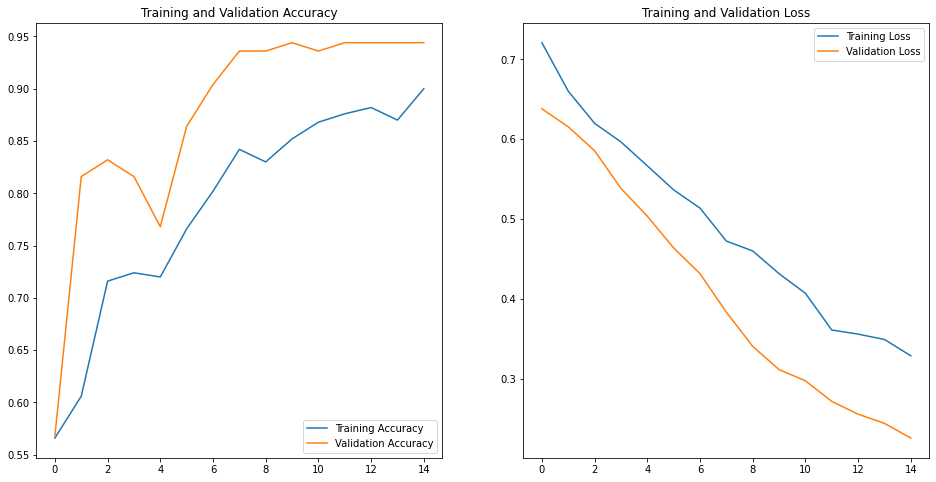

In [11]:
# Plot the training and validation accuracy and loss graphs

acc = model.history['acc']
val_acc = model.history['val_acc']

loss = model.history['loss']
val_loss = model.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing the model with a sample image from the test dataset

In [12]:
class_names = list(train_generator.class_indices.items())
print(class_names)

[('fake', 0), ('real', 1)]


In [13]:
test_image_path = "dataset/fake/10 rupees Images_ Stock Photos.jpg"

In [14]:
test_image_read_1 = cv2.imread(test_image_path)

test_image_1 = process_jpg_image(test_image_read_1)
prediction_1 = vgg.predict(test_image_1)
print(f'dimensions of image used for prediction is: ',test_image_1.shape)
print(prediction_1)

1/1 [==============================] - 0s 436ms/step
dimensions of image used for prediction is:  (1, 224, 224, 3)
[[0.80525815 0.1947418 ]]


## Predicting all the images in the test dataset and plotting a confusion matrix

In [15]:
# Get the labels of all the images
true_labels = validation_generator.labels
# Making the predictions of all the validation images
all_predictions = vgg.predict(validation_generator)

2/2 [==============================] - 24s 11s/step


In [16]:
preds = []
for items in all_predictions:
    preds.append(np.argmax(items))
    

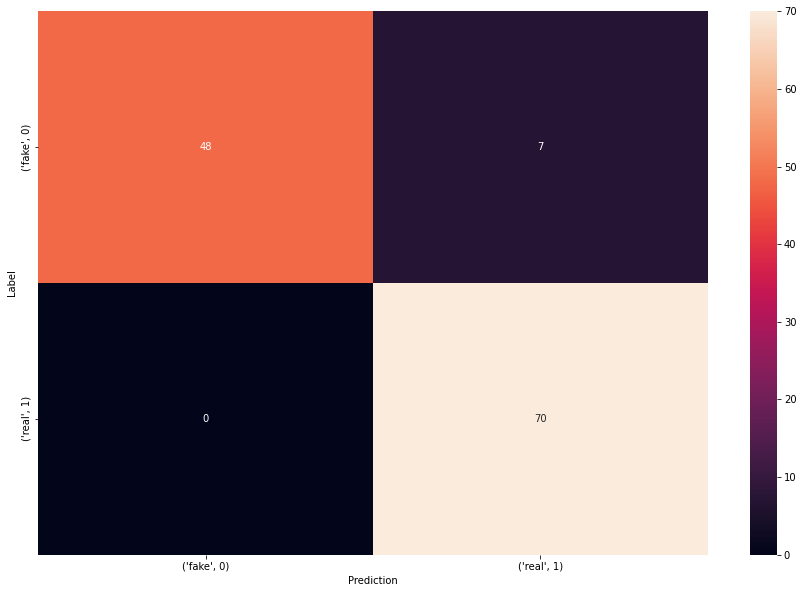

In [17]:
# plot the confusion matrix

confusion_mat = tf.math.confusion_matrix(
    true_labels, preds, dtype=tf.dtypes.int32)

show_confusion_matrix(confusion_mat, class_names)

In [18]:
f1 = f1_score(true_labels, preds, average='weighted')
print(f"F1 score of the model is", f1)

F1 score of the model is 0.9434304207119739


In [19]:
test_image_path = "dataset/fake/FIFTY RUPEE NOTES.jpg"
test_image_read_1 = cv2.imread(test_image_path)
test_image_1 = process_jpg_image(test_image_read_1)
prediction_1 = vgg.predict(test_image_1)
print(f'dimensions of image used for prediction is: ',test_image_1.shape)
print(prediction_1)

1/1 [==============================] - 0s 191ms/step
dimensions of image used for prediction is:  (1, 224, 224, 3)
[[0.9366643  0.06333572]]


In [20]:
import pickle 
with open('fake_currency_detector.pkl', 'wb') as f:
    pickle.dump(get_ipython().getoutput('jupyter nbconvert --to script notebook.ipynb'), f)


In [21]:
test_image_path = "dataset/real/2000_original_IMG_20190421_140542119.jpg_4b42b398-215d-416d-a1ce-9ad9fb75c8d1.jpg"
test_image_read_1 = cv2.imread(test_image_path)
test_image_1 = process_jpg_image(test_image_read_1)
prediction_1 = vgg.predict(test_image_1)
print(f'dimensions of image used for prediction is: ',test_image_1.shape)
print(prediction_1)

1/1 [==============================] - 0s 234ms/step
dimensions of image used for prediction is:  (1, 224, 224, 3)
[[0.31345487 0.68654513]]


In [22]:
vgg.save("vgg_model_2.h5")

C:\Users\dev24\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
test_image_path = "dataset/real/200_original_IMG_20190422_063730704.jpg_e8b9f697-aba9-45b4-8b88-48f9974661b9.jpg"
test_image_read_1 = cv2.imread(test_image_path)
test_image_1 = process_jpg_image(test_image_read_1)
prediction_1 = vgg.predict(test_image_1)
print(f'dimensions of image used for prediction is: ',test_image_1.shape)
print(prediction_1)

1/1 [==============================] - 0s 178ms/step
dimensions of image used for prediction is:  (1, 224, 224, 3)
[[0.04903756 0.9509624 ]]
